# Robot de Limpieza Reactivo
Este modelo estudia las estadísticas de un robot de limpieza reactivo, donde se recopila información

## Datos proporcionados
* Habitación de MxN espacios
* Número de agentes
* Porcentaje de celdas inicialmente sucias
* Tiempo máximo de ejecución

## Reglas
Las reglas del modelo son:
* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].
* En cada paso de tiempo:
    * Si la celda está sucia, entonces aspira.
    * Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda)
* Se ejecuta el tiempo máximo establecido

Para un espacio de 100x100, considera los siguientes escenarios:
* Escenario 1: 1 agente, 90% de celdas sucias
* Escenario 2. 2 agentes, 90% de celdas sucias

Deberás resolver las siguientes preguntas:
* ¿Cuántos pasos de simulación toma limpiar todo el espacio?
* ¿Qué porcentaje de celdas sucias queda con los siguientes pasos de simulación: 100, 1000, 10,000?

A continuación, determina cuál es la cantidad óptima de aspiradoras que debe de tener para realizar la limpieza en el menor tiempo posible. Considera que tenemos un máximo de 10 aspiradoras disponibles.

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import matplotlib.pyplot as plt

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time as tm

In [2]:
class VacuumAgent(Agent):
    def __init__(self, id, model, x, y):
        super().__init__(id, model)
        self.position = (x, y)

    def step(self):
        if model.dirty_cells.sum() == 0:
            model.running = False

        x_pos = self.position[0]
        y_pos = self.position[1]

        # Clean cell
        if model.dirty_cells[x_pos][y_pos] == 1:
            model.dirty_cells[x_pos][y_pos] = 0

        # Get new position
        possible_cells = self.model.grid.get_neighborhood(self.position, moore=True, include_center = False)
        new_position = self.random.choice(possible_cells)
        cellmate = self.model.grid.get_cell_list_contents([new_position])

        if cellmate:
            return

        self.position = new_position
        self.model.grid.move_agent(self, self.position)

In [3]:
def get_vacuums(model):
    return np.asarray([agent.position for agent in model.schedule.agents])

In [4]:
class VacuumModel(Model):
    def __init__(self, num_agents, width, height, dirty_cells_percent):
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, torus = False)
        self.datacollector = DataCollector(model_reporters={"Vacuums": get_vacuums})
        self.dirty_cells = np.zeros((width, height))
        self.dirty_cells_percent = dirty_cells_percent
        self.running = True

        # Initialize dirty cells
        init_dc = 0
        while init_dc < int(width * height * (dirty_cells_percent / 100)):
            x = int(np.random.rand() * width)
            y = int(np.random.rand() * height)
            if self.dirty_cells[x][y] == 0:
                self.dirty_cells[x][y] = 1
                init_dc += 1

        # Create agents and place them in [1, 1]
        for i in range(num_agents):
            x = 1
            y = 1
            agent = VacuumAgent(i, self, x, y)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        if self.running == False:
            return

        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
WIDTH = 100
HEIGHT = 100
DIRTY_CELLS_PERCENT = 90
ITERATIONS = [100,1000,10000]

In [6]:
def clean(model, iterations, num_vacuums):
  print("[CLEAN CELLS]")
  print(f"[AGENTS]: {num_vacuums}\n")

  for itr in iterations:
    time = tm.time()

    # Print labels
    print("Cleaning...")
    print(f"[ITERATIONS]: {itr}")

    for i in range(itr):
        model.step()

        if model.running == False:
           print(f"[FINISHED AT ITERATION]: {i}")
           break

    dc = model.dirty_cells.sum()
    dc_percent = dc / (WIDTH * HEIGHT) * 100

    # Print results
    print(f"[DIRTY CELLS LEFT]: {dc} ({round(dc_percent, 2)}%)")
    print(f"[TIME]: {round(tm.time() - time, 4)} seconds\n")

  print(f"----------------------\n")

In [7]:
def clean_all(model, num_vacuums):
  time = tm.time()
  steps = 0

  # Print labels
  print("[CLEAN ALL CELLS]")
  print(f"[AGENTS]: {num_vacuums}\n")
  print("Calculating time and steps to clean all cells...")

  while model.running == True:
      model.step()
      steps += 1

  # Print results
  print(f"[FINISHED AT]: {steps} steps")

  # Print time
  total_time = round(tm.time() - time, 4)
  print(f"[TIME]: {total_time} seconds\n")
  print(f"----------------------\n")
  return [steps, total_time]

## Escenario 1
* 1 agente
* 90% de celdas sucias.

In [8]:
NUM_VACUUMS = 1

# Steps needed to clean all cells
model = VacuumModel(NUM_VACUUMS, WIDTH, HEIGHT, DIRTY_CELLS_PERCENT)
clean_all(model, NUM_VACUUMS)

# For 100, 1000, 10000 iterations
model = VacuumModel(NUM_VACUUMS, WIDTH, HEIGHT, DIRTY_CELLS_PERCENT)
clean(model, ITERATIONS, NUM_VACUUMS)

[CLEAN ALL CELLS]
[AGENTS]: 1

Calculating time and steps to clean all cells...
[FINISHED AT]: 207998 steps
[TIME]: 5.3458 seconds

----------------------

[CLEAN CELLS]
[AGENTS]: 1

Cleaning...
[ITERATIONS]: 100
[DIRTY CELLS LEFT]: 8950.0 (89.5%)
[TIME]: 0.0937 seconds

Cleaning...
[ITERATIONS]: 1000
[DIRTY CELLS LEFT]: 8664.0 (86.64%)
[TIME]: 0.0156 seconds

Cleaning...
[ITERATIONS]: 10000
[DIRTY CELLS LEFT]: 6298.0 (62.98%)
[TIME]: 0.2536 seconds

----------------------



## Escenario 2
* 2 agentes
* 90% de celdas sucias.

In [9]:
NUM_VACUUMS = 2

# Steps needed to clean all cells
model = VacuumModel(NUM_VACUUMS, WIDTH, HEIGHT, DIRTY_CELLS_PERCENT)
clean_all(model, NUM_VACUUMS)

# For 100, 1000, 10000 iterations
model = VacuumModel(NUM_VACUUMS, WIDTH, HEIGHT, DIRTY_CELLS_PERCENT)
clean(model, ITERATIONS, NUM_VACUUMS)

[CLEAN ALL CELLS]
[AGENTS]: 2

Calculating time and steps to clean all cells...
[FINISHED AT]: 113413 steps
[TIME]: 4.9498 seconds

----------------------

[CLEAN CELLS]
[AGENTS]: 2

Cleaning...
[ITERATIONS]: 100
[DIRTY CELLS LEFT]: 8952.0 (89.52%)
[TIME]: 0.0156 seconds

Cleaning...
[ITERATIONS]: 1000
[DIRTY CELLS LEFT]: 8337.0 (83.37%)
[TIME]: 0.0313 seconds

Cleaning...
[ITERATIONS]: 10000
[DIRTY CELLS LEFT]: 3710.0 (37.1%)
[TIME]: 0.4273 seconds

----------------------



# Escenario 3
Cantidad óptima de aspiradoras

In [13]:
agents = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
steps = []
times = []

for i in agents:
    NUM_VACUUMS = i
    model = VacuumModel(NUM_VACUUMS, WIDTH, HEIGHT, DIRTY_CELLS_PERCENT)

    [_steps, _total_time] = clean_all(model, NUM_VACUUMS)
    steps.append(_steps)
    times.append(_total_time)

[CLEAN ALL CELLS]
[AGENTS]: 1

Calculating time and steps to clean all cells...
[FINISHED AT]: 290247 steps
[TIME]: 9.1236 seconds

----------------------

[CLEAN ALL CELLS]
[AGENTS]: 2

Calculating time and steps to clean all cells...
[FINISHED AT]: 170112 steps
[TIME]: 8.9743 seconds

----------------------

[CLEAN ALL CELLS]
[AGENTS]: 3

Calculating time and steps to clean all cells...
[FINISHED AT]: 86212 steps
[TIME]: 4.9451 seconds

----------------------

[CLEAN ALL CELLS]
[AGENTS]: 4

Calculating time and steps to clean all cells...
[FINISHED AT]: 74906 steps
[TIME]: 5.5871 seconds

----------------------

[CLEAN ALL CELLS]
[AGENTS]: 5

Calculating time and steps to clean all cells...
[FINISHED AT]: 60309 steps
[TIME]: 5.8158 seconds

----------------------

[CLEAN ALL CELLS]
[AGENTS]: 6

Calculating time and steps to clean all cells...
[FINISHED AT]: 55643 steps
[TIME]: 6.2107 seconds

----------------------

[CLEAN ALL CELLS]
[AGENTS]: 7

Calculating time and steps to clean a

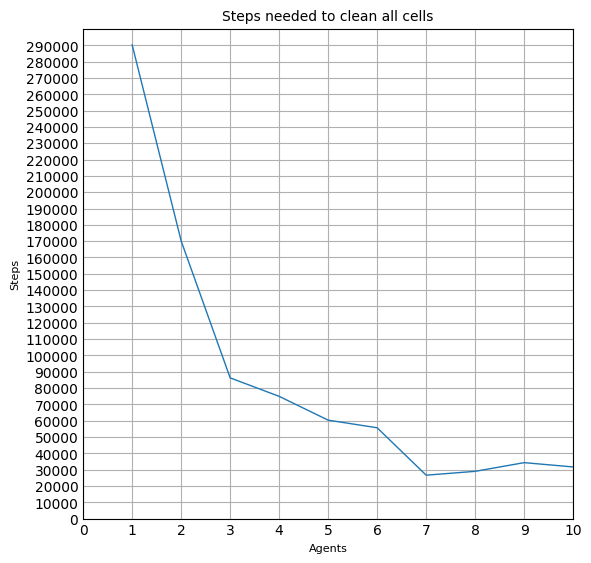

In [14]:
plt.style.use('_mpl-gallery')

# make data
x = agents
y = steps

# plot
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x, y, linewidth=1.0)

ax.set(xlim=(0, agents[-1]), xticks=np.arange(0, agents[-1] + 1),
       ylim=(0, max(steps) + 10000), yticks=np.arange(0, max(steps) + 1000, 10000)),

title = "Steps needed to clean all cells"
ax.set_title(title, fontsize=10)
ax.set_xlabel("Agents", fontsize=8)
ax.set_ylabel("Steps", fontsize=8)

plt.show()

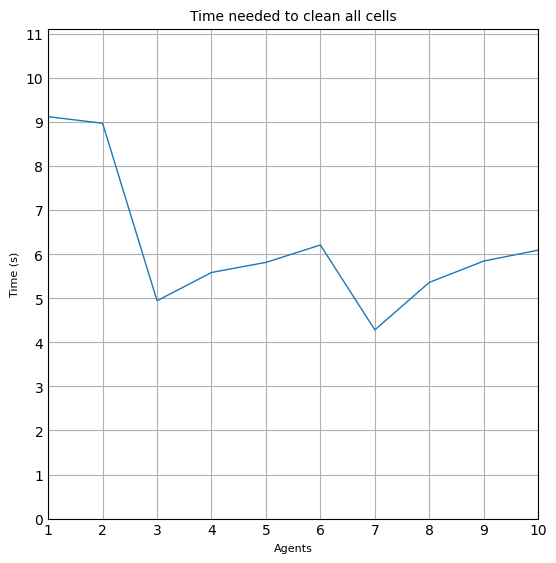

In [15]:
# make data
x = agents
y = times

# plot
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x, y, linewidth=1.0)

ax.set(xlim=(1, agents[-1]), xticks=np.arange(1, agents[-1] + 1),
       ylim=(0, max(times) + 2), yticks=np.arange(0, max(times) + 2, 1)),

title = "Time needed to clean all cells"
ax.set_title(title, fontsize=10)
ax.set_xlabel("Agents", fontsize=8)
ax.set_ylabel("Time (s)", fontsize=8)

plt.show()